<a href="https://colab.research.google.com/github/BigDataEngineer09/Cab-Price-Prediction/blob/main/Model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import  OneHotEncoder
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df=pd.read_csv('/content/drive/My Drive/OUTPUT_CSV/CabFirmCaseStudyMerged.csv')

In [9]:
df.head()

,Transaction_ID,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Travel_Date,Year,Month,Day,...,Payment_Mode,Gender,Age,Income,Population,Users,Holiday,Holiday_Indicator,Profit,Profit_Percentage
0,10000011,Pink Cab,ATLANTA GA,30.45,370.95,313.64,2016-01-08,2016,1,8,...,Card,Male,28,10813,814885,24701,0,0,57.32,15.45
1,10351127,Yellow Cab,ATLANTA GA,26.19,598.70,317.42,2018-07-21,2018,7,21,...,Cash,Male,28,10813,814885,24701,0,0,281.28,46.98
2,10412921,Yellow Cab,ATLANTA GA,42.55,792.05,597.40,2018-11-23,2018,11,23,...,Card,Male,28,10813,814885,24701,Thanksgiving Day,1,194.65,24.58
3,10412921,Yellow Cab,ATLANTA GA,42.55,792.05,597.40,2018-11-23,2018,11,23,...,Card,Male,28,10813,814885,24701,Thanksgiving Eve,1,194.65,24.58
4,10000012,Pink Cab,ATLANTA GA,28.62,358.52,334.85,2016-01-06,2016,1,6,...,Card,Male,27,9237,814885,24701,0,0,23.67,6.60


In [14]:
le_city = LabelEncoder()
le_company = LabelEncoder()
le_gender = LabelEncoder()
le_holidayIndicator = LabelEncoder()
le_Day_of_Week = LabelEncoder()
le_Month = LabelEncoder()
le_Year = LabelEncoder()

df['City_encoded'] = le_city.fit_transform(df['City'])
df['Company_encoded'] = le_company.fit_transform(df['Company'])
df['Gender_encoded'] = le_gender.fit_transform(df['Gender'])
df['Is_Holiday_encoded'] = le_city.fit_transform(df['Holiday_Indicator'])
df['Day_of_Week_encoded'] = le_company.fit_transform(df['Day'])
df['Month_encoded'] = le_gender.fit_transform(df['Month'])
df['Year_encoded'] = le_gender.fit_transform(df['Year'])

In [15]:
d=df[['Day','Day_of_Week_encoded']]
d.sample(5)

,Day,Day_of_Week_encoded
69582,17,16
231780,20,19
273912,24,23
87510,26,25
125560,23,22


In [32]:
x = df[['KM_Travelled', 'City_encoded', 'Company_encoded', 'Gender_encoded']]
y = df['Price_Charged']

The KM_Travelled has the strongest correlation with Price_Charged but we can  still build a model to predict price based on city and distance travelled, even if the correlation with city is weak.

**Reason:**

``Non-linear relationships:`` Correlation only measures linear relationships. Even if a feature (city) has a weak linear correlation, it might still have a non-linear relationship with the target price. A model can capture these non-linear patterns.
Interaction effects: The price might depend on the interaction between city and distance travelled. For example, a short trip in a congested city might be more expensive than a long trip in a less crowded city, even though the distance travelled is lower. A model can capture these interaction effects.
Here are some things to consider when deciding whether to build a model with city and distance:

``Data size:`` We have a large amount of data, even weak correlations can be statistically significant and informative for a model.

``Model interpretability:`` If interpretability is important, focusing on features with high correlation (like KM_Travelled) might be better. Complex models that capture weak correlations can be harder to interpret.

Ultimately, the best way to decide is to experiment and compare the performance of models with and without city as a feature. You can use techniques like cross-validation to get a reliable estimate of how well each model generalizes to unseen data.

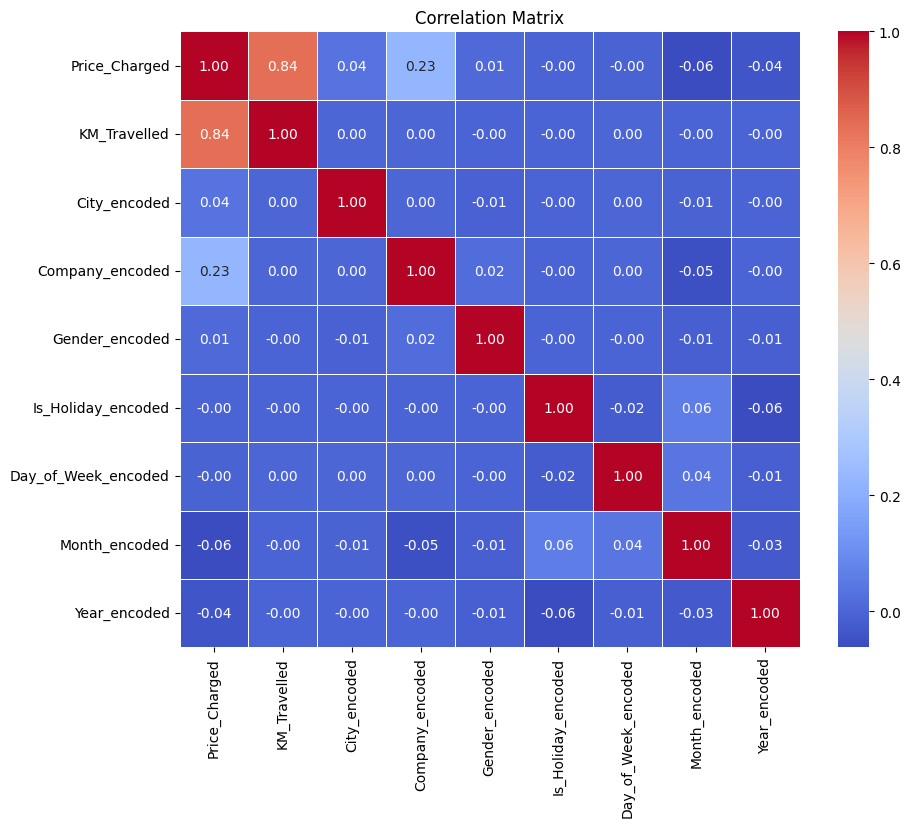

In [30]:
data = df[['Price_Charged','KM_Travelled', 'City_encoded', 'Company_encoded', 'Gender_encoded','Is_Holiday_encoded', 'Day_of_Week_encoded', 'Month_encoded', 'Year_encoded']]
numerical_features = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_features.corr()
#print("Correlation Matrix:")
#print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f"train dataset features size: {x_train.shape}")
print(f"train dataset label size: {y_train.shape}")

print(f"test dataset features size: {x_test.shape}")
print(f"test dataset label size: {y_test.shape}")

train dataset features size: (292664, 4)
train dataset label size: (292664,)
test dataset features size: (73166, 4)
test dataset label size: (73166,)


In [34]:
def evaluate_regression_model(model, X_test, y_test, model_name="Model"):
    # Predict target values on testing data
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    metrics = {
        'Mean Square Error': mse,
        'Mean Absolute Error': mae,
        'Root Mean Squared Error ': rmse,
        'R-squared ': r2,
        'Mean Absolute Percentage Error': mape
    }

    print(f"\033[1m EVALUATION METRICS ({model_name}) \033[0m")
    print(f"\nMean Squared Error          : {mse}")
    print(f"Mean Absolute Error           : {mae}")
    print(f"Root Mean Squared Error       : {rmse}")
    print(f"R-squared                     : {r2}")
    print(f"Mean Absolute Percentage Error: {mape}")


    return metrics, y_pred


In [42]:
from sklearn.model_selection import cross_val_score

In [60]:
#Linear Regression
linear_model = LinearRegression()

linear_model.fit(x_train, y_train)
metrics_linear, y_pred_linear = evaluate_regression_model(linear_model, x_test, y_test, model_name="Linear Regression")
scores = cross_val_score(linear_model, x_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

 EVALUATION METRICS (Linear Regression) 

Mean Squared Error          : 18552.964197127072
Mean Absolute Error           : 98.98613146063553
Root Mean Squared Error       : 136.20926619407018
R-squared                     : 0.7539922004628612
Mean Absolute Percentage Error: 0.32036005147613744
0.75 accuracy with a standard deviation of 0.00


In [53]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)  # Adjust alpha as needed for regularization strength
ridge_model.fit(x_train, y_train)
metrics_ridge, y_pred_ridge = evaluate_regression_model(ridge_model, x_test, y_test, model_name="Ridge Regression")
scores = cross_val_score(ridge_model, x, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

 EVALUATION METRICS (Ridge Regression) 

Mean Squared Error          : 18552.96427397872
Mean Absolute Error           : 98.98594727505984
Root Mean Squared Error       : 136.20926647617893
R-squared                     : 0.753992199443827
Mean Absolute Percentage Error: 0.32035705333755227
0.39 accuracy with a standard deviation of 0.51


In [54]:
# Lasso Regression
lasso_model = Lasso(alpha=1.0)  # Adjust alpha as needed for regularization strength
lasso_model.fit(x_train, y_train)
metrics_lasso, y_pred_ridgelasso  = evaluate_regression_model(lasso_model, x_test, y_test, model_name="Lasso Regression")
scores = cross_val_score(lasso_model, x, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

 EVALUATION METRICS (Lasso Regression) 

Mean Squared Error          : 18560.995485435018
Mean Absolute Error           : 98.65222516712221
Root Mean Squared Error       : 136.2387444357699
R-squared                     : 0.7538857075303522
Mean Absolute Percentage Error: 0.3145825537919287
0.39 accuracy with a standard deviation of 0.50


In [56]:
# Polynomial Regression
degree = 2  # Choose the degree of polynomial features
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(x_train, y_train)
metrics_poly, y_pred_poly = evaluate_regression_model(poly_model, x, y, model_name="Polynomial Regression")
scores = cross_val_score(poly_model, x, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

 EVALUATION METRICS (Polynomial Regression) 

Mean Squared Error          : 13192.02851105969
Mean Absolute Error           : 82.44215681684446
Root Mean Squared Error       : 114.8565562389004
R-squared                     : 0.8246334170665189
Mean Absolute Percentage Error: 0.2757182506020782
0.57 accuracy with a standard deviation of 0.31


In [57]:
# Bayesian Linear Regression
bayesian_model = BayesianRidge()
bayesian_model.fit(x_train, y_train)
metrics_bayesian, y_pred_bayesian = evaluate_regression_model(bayesian_model, x_test, y_test, model_name="Bayesian Linear Regression")
scores = cross_val_score(bayesian_model, x, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

 EVALUATION METRICS (Bayesian Linear Regression) 

Mean Squared Error          : 18552.96446962241
Mean Absolute Error           : 98.98550565099048
Root Mean Squared Error       : 136.20926719435212
R-squared                     : 0.7539921968496391
Mean Absolute Percentage Error: 0.32034986466387555
0.39 accuracy with a standard deviation of 0.51


In [58]:
# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed
rf_regressor.fit(x_train, y_train)
metrics_rf, y_pred_rf = evaluate_regression_model(rf_regressor, x_test, y_test, model_name="Random Forest Regressor")
scores = cross_val_score(rf_regressor, x, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

 EVALUATION METRICS (Random Forest Regressor) 

Mean Squared Error          : 7450.456669254062
Mean Absolute Error           : 57.5673027596167
Root Mean Squared Error       : 86.31602788158212
R-squared                     : 0.9012087539610618
Mean Absolute Percentage Error: 0.13906232394519685
0.87 accuracy with a standard deviation of 0.02


In [59]:
# Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(x_train, y_train)
metrics_dt, y_pred_dt = evaluate_regression_model(dt_regressor, x_test, y_test, model_name="Decision Tree Regressor")
scores = cross_val_score(dt_regressor, x, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

 EVALUATION METRICS (Decision Tree Regressor) 

Mean Squared Error          : 7887.556132461856
Mean Absolute Error           : 58.93424715234719
Root Mean Squared Error       : 88.81191436097893
R-squared                     : 0.8954129212315799
Mean Absolute Percentage Error: 0.14286620894867644
0.86 accuracy with a standard deviation of 0.02


From the evaluation metrics provided for each regression model, we can interpret the following:

1. **Mean Squared Error (MSE)**: This metric measures the average squared difference between the predicted and true values. Lower values of MSE indicate better model performance.

2. **Mean Absolute Error (MAE)**: MAE measures the average absolute difference between the predicted and true values. Like MSE, lower values of MAE indicate better model performance.

3. **Root Mean Squared Error (RMSE)**: RMSE is the square root of the MSE. It provides an interpretable measure of error in the same units as the target variable. Again, lower values of RMSE indicate better model performance.

4. **R-squared (R²)**: R-squared represents the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). It ranges from 0 to 1, where 1 indicates a perfect fit. Higher values of R² indicate better model performance.

5. **Mean Absolute Percentage Error (MAPE)**: MAPE calculates the average percentage difference between the predicted and true values. Lower values of MAPE indicate better model performance.

**Based on these metrics:**

- Random Forest Regressor has the lowest MSE, MAE, and RMSE among the models, indicating better performance in terms of prediction accuracy.
- Random Forest Regressor also has the highest R-squared value, indicating that it explains more of the variance in the target variable compared to other models.
- Bayesian Linear Regression has the highest MSE, MAE, and RMSE, indicating poorer performance compared to other models.
- Bayesian Linear Regression also has the lowest R-squared value, indicating that it explains less of the variance in the target variable compared to other models.

In summary, **Random Forest Regressor** seems to be the **best-performing model** based on these evaluation metrics.